# Curso Análisis de Redes

## Cátedra Teoría de las Telecomunicaciones - Universidad ORT Uruguay



# Control de congestión en redes (4a. parte)

In [1]:
#using Pkg;Pkg.instantiate(); Pkg.update()

## Más allá de TCP/Reno

 * El algoritmo de Control de Congestión de TCP sobrevivió (y posibilitó) la explosión de Internet en los años 90.

 * La razón de su éxito es precisamente que logra una asignación *adecuada* y *eficiente* de manera *completamente descentralizada*.
 
 * Sin embargo, a comienzos de la década del 2000, se vio que era insuficiente para redes con alto producto retardo por ancho de banda ($C\times d$).

### Problemas con alto retardo

 * En las redes con alto retardo, aparecieron fenómenos de sincronización y oscilaciones.
 * Esto se debe al *retardo en el lazo de control*, porque reaccionamos tarde a las pérdidas.
 * A su vez, RTTs más grandes degradan la velocidad por la fórmula de Mathis, como ya vimos.

### Problemas con alto ancho de banda

 * El mecanismo de bajada de TCP requiere demasiados RTTs para subir la ventana si $W_{max}$ es grande.
 * Esto puede hacer que la ventana opere mucho tiempo por debajo de la óptima (ver ejercicio del obligatorio)
 * Otra forma de evidenciar este problema es también usando la fórmula de Mathis:
 
 > **Ejemplo:** Supongamos que una fuente TCP tiene un $RTT$ de $200ms$ y el enlace es de $50Mbps$ (ej. fibra). Operando con paquetes de $1500$ bytes la fórmula de Mathis indica que:
 >
 > $$ x = \frac{1500\times 8}{0.2}\sqrt{\frac{1.5}{p}}.$$
 >
 > De donde, si queremos qe $x=50Mbps$, necesitamos:
 >
 > $$ p \approx 2\times 10^{-6}$$
 
De lo anterior, se pierde un paquete cada aproximadamente $500.000$, es decir ¡$1$ paquete cada $715$ MBytes transmitidos! Solo los flujos muy largos ven esto.


## Alternativas a TCP/Reno:

Durante los años 2000 se propusieron innumerables alternativas para solucionar los problemas de TCP/Reno:

* High Speed TCP
* TCP-Westwood
* TCP-Illinois
* Fast TCP
* Compound TCP
* STCP
* TCP-BIC
* TCP Cubic
* etc. etc.

Hoy en día, la alternativa más utilizada es [**TCP-Cubic**](https://tools.ietf.org/html/rfc8312).

### TCP - Cubic

<img style="float:right; width:350px; padding-left: 2em" src="../images/cubic_window.png"/>

**Ideas clave:**

* Ser más agresivo en la subida de ventana para volver al punto de pérdida.

* Luego de volver, comenzar una fase de probing para subir la ventana.

* Al ver una pérdida, bajar un porcentaje menor al $50\%$.

* Hacer que la fase de subida y probing *no dependan del $RTT$* sino del tiempo absoluto desde la congestión.

El resultado fue una parábola cúbica sin demasiada explicación de por qué:

$$\begin{array}{lcr}cwnd\ =\ C(T-K)^{3}+w_{max}\\ K={\sqrt[{3}]{\frac {w_{max}(1-\beta )}{C}}}\end{array}$$

Con:

 - β SHOULD be set to 0.7 (Section 4.5)
 - C SHOULD be set to 0.4 (Section 5)

El algoritmo se popularizó y fue tomado inmediatamente por Linux (ergo, por casi todos los servidores de Internet) y luego por Windows.

<img style="float: center; width:500px" src="../images/cubic_window_2.png"/>


### Cubic vs. Reno

Para ver el comportamiento comparado de Cubic vs. Reno realizamos la siguiente prueba en un enlace cuello de botella de $C=10Mbps$ y $d=100ms$. Ventana óptima $W^* = 83$ paq.

In [2]:
using CSV, DataFrames, Plots, LaTeXStrings
default(size=(900,400), legend=:bottomright, legendfontsize=10)

df = CSV.File("../datos/cubic_vs_reno.tr", header=false) |> DataFrame

,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,Float64,String15,String15,Int64,String15,String15,Int64
1,1.54529,10.0.0.1:57719,10.0.0.2:5001,32,0x49f82b42,0x49f80ee2,10
2,1.54532,10.0.0.1:57719,10.0.0.2:5001,32,0x49f82b42,0x49f80efa,10
3,1.54661,10.0.0.1:57719,10.0.0.2:5001,32,0x49f84d32,0x49f814a2,10
4,1.54771,10.0.0.1:57719,10.0.0.2:5001,32,0x49f852da,0x49f81a4a,10
5,1.54901,10.0.0.1:57719,10.0.0.2:5001,32,0x49f852da,0x49f81ff2,10
6,1.55028,10.0.0.1:57719,10.0.0.2:5001,32,0x49f852da,0x49f8259a,10
7,1.74601,10.0.0.1:57719,10.0.0.2:5001,32,0x49f863d2,0x49f82b42,10
8,1.74721,10.0.0.1:57719,10.0.0.2:5001,32,0x49f8697a,0x49f830ea,10
9,1.74846,10.0.0.1:57719,10.0.0.2:5001,32,0x49f8697a,0x49f83692,10


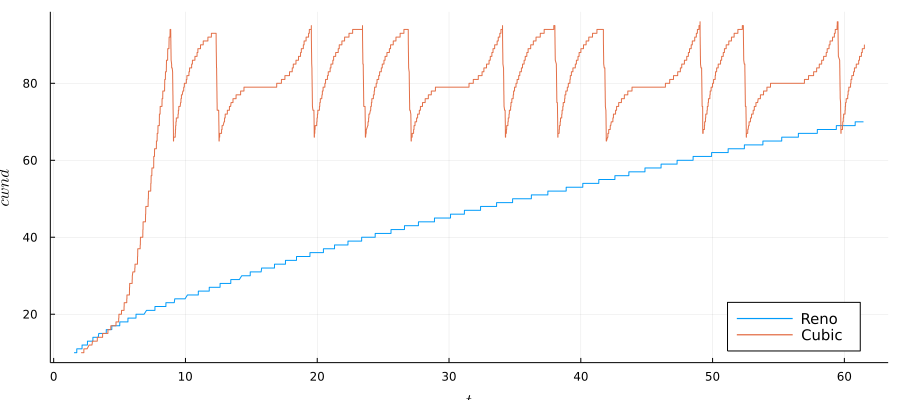

In [3]:
df1 = filter(row-> occursin("57719",row[2]),df) #me quedo con las conexiones del puerto 57719
df2 = filter(row-> occursin("57720",row[2]),df)

t1 = df1[!,1]
w1=df1[!,7]
t2 = df2[!,1]
w2=df2[!,7]

plot([t1,t2],[w1,w2], label=["Reno" "Cubic"], xlabel=L"t", ylabel=L"cwnd")

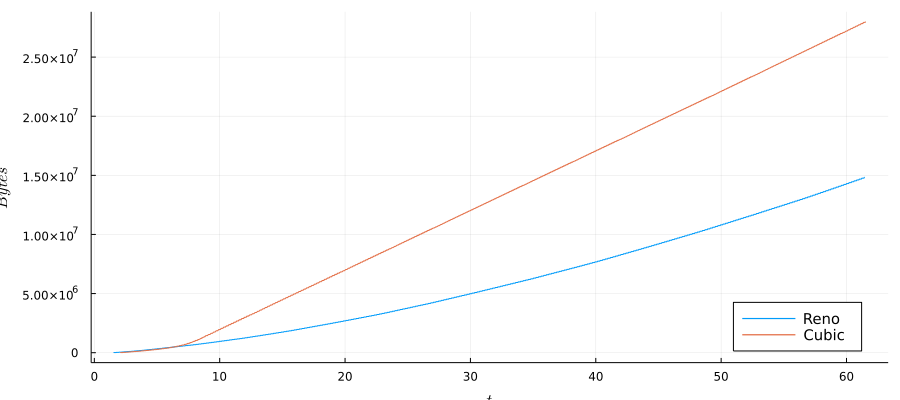

In [4]:
seq1 = parse.(Int64,df1[!,5])
seq1 = seq1 .-seq1[1]
seq2 = parse.(Int64,df2[!,5])
seq2 = seq2 .-seq2[1]
plot([t1,t2],[seq1,seq2], label=["Reno" "Cubic"], xlabel=L"t", ylabel=L"Bytes")

## Últimos progresos

En los últimos años, el tema del control de congestión ha vuelto a ser rediscutido básicamente en dos contextos:

 * **Data Centers:** aquí las conexiones tienen anchos de banda gigantescos pero retardos minúsculos. Las necesidades son bien distintas. En 2010 se propuso DataCenter TCP (DCTCP) para encarar este caso.
 
 * **Big-Fat-Networks** este es el contexto donde Cubic superó a Reno, pero con el crecimiento del ancho de banda, operar en base a pérdidas no parece una buena idea.
 


**Idea:** Medir el RTT de la conexión y operar en base a retardo y no pérdidas.

### TCP basado en retardos.

* Es una vieja idea. Fue propuesta por Bramko y Peterson en TCP-Vegas en los 1994.

  *  **Idea:** medir el RTT de la conexión. Cuando empieza a aumentar es porque saturamos el enlace y comenzó a encolar.
 
* Podemos pensar que el *retardo de cola* es el precio del enlace, en lugar de la probabilidad de pérdida.
 
* Si es una única conexión funciona bárbaro.

* **Problema:** si una conexión entre luego que otra, ya ve el enlace cargado y no tiene una buena estimación del retardo de propagación base.

* En el año 2000 se propne TCP-Fast, basado en la misma idea pero con argumentos de diseño más matemáticos.

### TCP BBR (Bottleneck bandwidth and RTT)

* [Propuesto](https://github.com/google/bbr) por Google en 2016. Es de [código abierto](https://git.kernel.org/pub/scm/linux/kernel/git/netdev/net-next.git/tree/net/ipv4/tcp_bbr.c).

* Se basa en la idea de estimar el RTT de la conexión, por lo que sufre en principio de los mismos problemas de injusticia temporal que las variantes anteriores.

* Sin embargo, dicen que opera mejor. Hay que estudiarlo. Posiblemente sea la próxima etapa.